In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import os
import json
from PIL import Image
from keras.models import model_from_json


In [ ]:
# !unzip './drive/MyDrive/AML/processed/stable.zip'

In [ ]:
print(tf.__version__)

2.4.1


In [20]:
def get_image(path):
  img = Image.open(path).convert('L')
  if img.width < 40: return None
  s = (img.width,img.height)
  # print(s)
  img = img.resize((65,40))
  arr = np.asarray(img).reshape(40,65,1)
  # print(arr.shape)
  return arr, s

In [5]:
def to_category(x,y,n):
  num = x*n + y
  res = np.zeros(n*n)
  res[num] = 1
  return res

In [7]:
grid_size = 4

In [21]:
def populate_imgs(folder):  # extract the dataset to form the model's input

  imgs = os.listdir('./'+folder)
  x_train = []
  y_train = []
  toplefts = []
  
  xscale = 1920//grid_size
  yscale = 1080//grid_size

  for img1 in imgs:
    if img1.split('.')[1] != 'jpg': continue
    
    I1,S1 = get_image('./'+folder+'/'+img1)
    
    img = img1.split('.')[0].split('_')

    row = int(img[0])
    col = int(img[1])
    topleft = eval(img[3])
    
    x_train.append(I1)
    toplefts.append([(topleft[0]) / 848, (topleft[1]) / 480])
    y_train.append(to_category(row,col,grid_size))

    
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  toplefts = np.array(toplefts)

  return x_train,y_train,toplefts

In [51]:
x_train, y_train, top_lefts = populate_imgs('stable')
x_train2, y_train2, top_lefts2 = populate_imgs('stable2')

Eye position: [0.19221698 0.41458333]
Eye image:


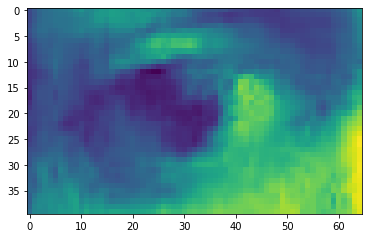

Grid cell: [0, 0]


In [52]:
print('Eye position:',top_lefts[4])
print('Eye image:')
plt.imshow(x_train[4].reshape(40,65))
plt.show()
print('Grid cell:',[0,0])

Eye position: [0.22051887 0.26875   ]
Eye image:


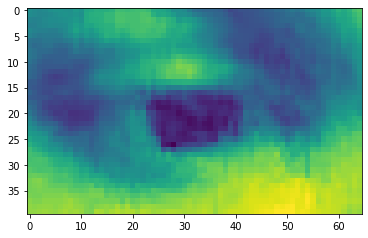

Grid cell: [0, 0]


In [53]:
print('Eye position:',top_lefts2[4])
print('Eye image:')
plt.imshow(x_train2[4].reshape(40,65))
plt.show()
print('Grid cell:',[0,0])

In [54]:
# shuffling the data

inds = list(range(x_train.shape[0]))
np.random.shuffle(inds)

x_train = x_train[inds]

y_train = y_train[inds]
top_lefts = top_lefts[inds]

In [55]:
# shuffling the data

inds = list(range(x_train2.shape[0]))
np.random.shuffle(inds)

x_train2 = x_train2[inds]

y_train2 = y_train2[inds]
top_lefts2 = top_lefts2[inds]

In [97]:
# counting the number of samples for each class

counts = [0 for _ in range(grid_size**2)]
for y in y_train[:2500]:
  counts[np.argmax(y)]+=1
print(counts)
counts = [0 for _ in range(grid_size**2)]
for y in y_train[2500:]:
  counts[np.argmax(y)]+=1
print(counts)

In [56]:
# Learning rate Scheduler

def scheduler (epochs, lr):
  # return lr
  if epochs == 25:
    return 0.0001
  if epochs == 50:
    return 0.00001
  if epochs == 75:
    return 0.000001
  else: return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [88]:
# Model for 1 eye image (left)

image_l = Input(shape=(40,65,1))
vals_l = Input(2,)
# print(image.shape)
x = Conv2D(32,(3,3),activation='relu', padding='same')(image_l)
x = MaxPooling2D((2,2))(x)
# x = # Dropout(0.4)(x)
x = Conv2D(64,(3,3),activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128,(2,2),activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)
x = Conv2D(256,(2,2),activation='relu', padding='same')(x)
x = Dropout(0.1)(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
out_l = Dense(300,activation='relu')(x)

img_model_l = tf.keras.Model(inputs=image_l, outputs=out_l)

y_l = Dense(5,activation='relu')(vals_l)

pos_model_l = tf.keras.Model(inputs=vals_l, outputs=y_l)

combined_l = concatenate([img_model_l.output, pos_model_l.output])

z = Dropout(0.4)(combined_l)
z = Dense(50,activation='relu')(z)

z = Dense(30, activation='relu')(z)
z = Dense(grid_size**2,activation='sigmoid')(z)

combined_model = tf.keras.Model(inputs=[img_model_l.input, pos_model_l.input],outputs=z)


In [ ]:
# Plot model architecture
dot_img_file = './temp.png'
tf.keras.utils.plot_model(combined_model, to_file=dot_img_file, show_shapes=True)

In [89]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
combined_model.compile(opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [87]:
ind = 2800
X_train = [np.concatenate([x_train[:ind],x_train2[:ind]]),np.concatenate([top_lefts[:ind],top_lefts2[:ind]])]
Y_train = np.concatenate([y_train[:ind],y_train2[:ind]])

X_test = [np.concatenate([x_train[ind:],x_train2[ind:]]),np.concatenate([top_lefts[ind:],top_lefts2[ind:]])]
Y_test = np.concatenate([y_train[ind:],y_train2[ind:]])

In [90]:
combined_history = combined_model.fit(X_train,Y_train, epochs=100, batch_size=32, callbacks=[callback], validation_data=(X_test,Y_test))

Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 3.4167 - accuracy: 0.0634 - val_loss: 2.7705 - val_accuracy: 0.0702
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 2.7710 - accuracy: 0.0574 - val_loss: 2.6724 - val_accuracy: 0.1102
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 2.5151 - accuracy: 0.1480 - val_loss: 1.7692 - val_accuracy: 0.3850
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 1.5917 - accuracy: 0.3977 - val_loss: 1.1951 - val_accuracy: 0.6380
Epoch 5/100
175/175 [==============================] - 1s 6ms/step - loss: 1.1937 - accuracy: 0.5374 - val_loss: 0.8063 - val_accuracy: 0.7567
Epoch 6/100
175/175 [==============================] - 1s 6ms/step - loss: 0.9715 - accuracy: 0.6349 - val_loss: 0.6989 - val_accuracy: 0.8015
Epoch 7/100
175/175 [==============================] - 1s 6ms/step - loss: 0.8371 - accuracy: 0.6861 - val_loss: 0.6171 - val_accuracy: 0.8390

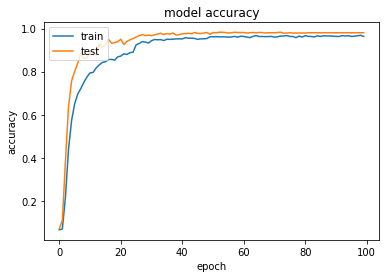

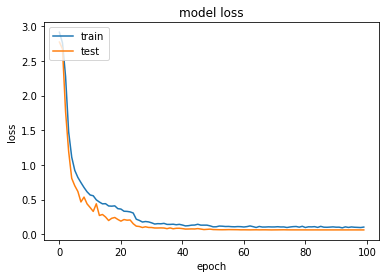

In [91]:
plt.plot(combined_history.history['accuracy'])
plt.plot(combined_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(combined_history.history['loss'])
plt.plot(combined_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
def get_euclidean_loss():
  preds = combined_model.predict(X_test)
  s = 0
  counter = 0
  for i in range(len(preds)):
    row1,col1 = convert_to_grid(preds[i])
    row2,col2 = convert_to_grid(Y_test[i])
    
    x1 = (1920//grid_size) * (col1 + np.random.random() - 0.5)
    y1 = (1080//grid_size) * (row1 + np.random.random() - 0.5)
    x2 = (1920//grid_size) * (col2 + np.random.random() - 0.5)
    y2 = (1080//grid_size) * (row2 + np.random.random() - 0.5)

    s += np.sqrt((x2-x1)**2 + (y2-y1)**2)

  return s / len(preds)


In [93]:
euc_loss = get_euclidean_loss()

print('Average inaccuracy rate (in pixels):',euc_loss)

Average inaccuracy rate (in pixels): 231.9237824158517


In [42]:
def convert_to_grid(arr):
  n = np.argmax(arr)
  # print(arr)
  # return 'row '+str(n%grid_size)+', col '+str(n//grid_size)
  return [n//grid_size, n%grid_size]

In [ ]:
model.evaluate(x_train2,y_train2)

51/51 [==============================] - 1s 7ms/step - loss: 3.2487 - accuracy: 0.1782


[3.248728036880493, 0.1782178282737732]

In [ ]:
def show_examples(model,x_arr,y_arr):
  preds = model.predict(x_arr)

  inds = list(range(len(x_arr[0])))
  np.random.shuffle(inds)

  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_arr[0][inds[i]].reshape(40,65))

      plt.xlabel('G: '+str(convert_to_grid(preds[inds[i]])) + ' T: '+ str(convert_to_grid(y_arr[inds[i]])))
  plt.show()

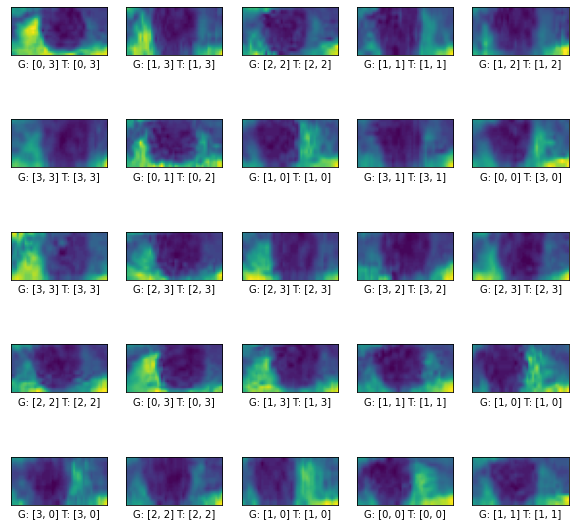

In [ ]:
show_examples(model,[x_train[2500:],[]],y_train[2500:])

In [94]:
combined_model.save_weights("final_model.h5")

In [96]:
model_json = combined_model.to_json()

In [97]:
with open("./final_model.json", "w") as json_file:
    json_file.write(model_json)